In this script, we download the ICESAT2 data using the OpenAltimetry API for the region of interest (Brahmaputra river) and save it in parquet file format as '../data/out/icesat-2-BGD.parquet':

In [1]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt 

import json

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import box, Polygon
from pyproj import CRS
from tqdm.notebook import tqdm
from tqdm import trange

In [2]:
# remove folium warning
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [3]:
dates = requests.get('https://openaltimetry.org/data/icesat2/getTrackDate').json()
tracks = gpd.read_file(r"../data/icesat-2/icesat2_tracks.shp")

# NL
# extents = [5.35,53.4,6.2,53.5] 
#extents = [5.8062744140625, 53.36202615413913, 6.1791229248046875, 53.5092846887053]
# zoom = 10

# DK
# extents = [8.0557, 54.8955, 8.7615, 55.5938]
# zoom = 8

# FR
#extents = [-1.28608, 44.60415, -0.9908, 44.7969]
#zoom = 10

# Bangladesh
#extents = [87.82464370120167, 26.682156997156508, 92.5, 21.581176369642726]
#extents = [89.42267656397932, 24.5, 89.96649980616682, 23.7] #needs to be readjusted
#extents = [89.42267656397932, 23.7, 89.96649980616682, 24.5]
extents = [89.57958670206244, 23.721136875400937, 89.99453684543461, 24.618409448937893] #Extent same as users/gena/AquaMonitor2020/bathymetry-jamuna/bathymetry3-jamuna-2018-2019
zoom = 9

polygon_geom = Polygon(zip([extents[0],extents[2],extents[2],extents[0]], [extents[1],extents[1],extents[3],extents[3]]))
polygon = gpd.GeoDataFrame(index=[0], crs=CRS('EPSG:4326'), geometry=[polygon_geom])       

# Clip data
tracks_clip = gpd.clip(tracks, polygon)
track_ids = tracks_clip.TrackId.values

In [4]:
center = [polygon_geom.centroid.xy[1][0], polygon_geom.centroid.xy[0][0]]

In [5]:
m = folium.Map(center, zoom_start=zoom)
folium.GeoJson(polygon_geom).add_to(m)
folium.GeoJson(tracks_clip).add_to(m)
folium.LatLngPopup().add_to(m)
m


In [6]:
track_ids

array(['180', '622', '797', '1239'], dtype=object)

In [7]:
# track_id, track_date
overpasses = []
for track_id in track_ids:
    for track_date in dates['track_{}'.format(track_id)].split(','):
        overpasses.append([track_id, track_date])



In [8]:
#print(overpasses)

In [9]:
rows = []

# download data for all track_id, track_date combinations
with tqdm(overpasses, ncols='100%') as t:
    log = lambda s: t.set_description(s); t.refresh()
    
    for track_id, track_date in t:
        log(f'Downloading data for track: {track_id}, date: {track_date}')

        # Paste the OpenAltimetry API URL for Photon here: 
        OA_API_URL = 'https://openaltimetry.org/data/api/icesat2/atl03?' \
            '&minx={}&miny={}&maxx={}&maxy={}&date={}&trackId={}' \
            '&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l' \
            .format(extents[0], extents[1], extents[2], extents[3], track_date, track_id)

        # This function will request the 6 beams data using OpenAltimetry's API
        r = requests.get(OA_API_URL + '&client=jupyter')
        photon_data = r.json()

        # iterate over 6 beams
        for beam in photon_data:
            # every beam has data series with different confidences:
            #
            # {'beam_name': 'gt3r',
            #  'total_photon_count': 43383,
            #  'select_photon_count': 43383,
            #  'percentage': 100.0,
            #  'series': [{'name': 'Noise',
            #    'photon_count': 580,
            #    'data': [[55.48735236638138, 8.49802945875813, 37.546936],
            #     [55.48734604692815, 8.498028327844818, 42.50964],            
            beam_name = beam['beam_name']
            for s in beam['series']:
                # every series has name (confidence)
                series_name = s['name']
                
                for o in s['data']:
                    # add rows
                    row = {
                        'track_id': track_id,
                        'date': track_date,
                        'beam': beam_name,
                        'series': series_name,
                        'lon': round(o[1], 6),
                        'lat': round(o[0], 6),
                        'h': o[2],
                    }
            
                    rows.append(row)

#Save locally after downloading once

In [10]:
#print(photon_data)

In [11]:
#print(beam)

In [12]:
print(type(beam))

<class 'dict'>


In [13]:
beam['beam_name']

'gt1l'

In [14]:
#print(photon_data)

In [15]:
print(beam)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
df = pd.DataFrame(rows)

In [17]:
df

,track_id,date,beam,series,lon,lat,h
0,180,2019-01-09,gt3r,Noise,89.622678,23.727912,3.698254
1,180,2019-01-09,gt3r,Noise,89.622680,23.727912,-30.436510
2,180,2019-01-09,gt3r,Noise,89.622685,23.727913,-103.526760
3,180,2019-01-09,gt3r,Noise,89.622679,23.727918,-19.456028
4,180,2019-01-09,gt3r,Noise,89.622678,23.727918,-9.291720
...,...,...,...,...,...,...,...
4150038,1239,2020-03-16,gt1l,High,89.751855,23.721827,-47.611958
4150039,1239,2020-03-16,gt1l,High,89.751852,23.721802,-47.792526
4150040,1239,2020-03-16,gt1l,High,89.751844,23.721725,-47.442990
4150041,1239,2020-03-16,gt1l,High,89.751837,23.721668,-47.488422


In [18]:
df.memory_usage()

Index            128
track_id    33200344
date        33200344
beam        33200344
series      33200344
lon         33200344
lat         33200344
h           33200344
dtype: int64

<AxesSubplot:>

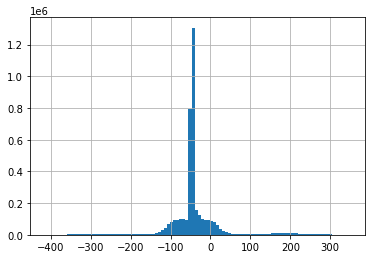

In [19]:
df.h.hist(bins=100)

In [20]:
df.to_parquet('../data/out/icesat-2-BGD.parquet')

In [21]:
df.columns

Index(['track_id', 'date', 'beam', 'series', 'lon', 'lat', 'h'], dtype='object')

In [22]:
df.series.unique()

array(['Noise', 'Buffer', 'Low', 'Medium', 'High'], dtype=object)

In [23]:
df.beam.unique()

array(['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l'], dtype=object)

In [24]:
track_ids = df.track_id.unique()
track_ids

array(['180', '622', '797', '1239'], dtype=object)

In [25]:
[ [track_id, df[df.track_id == track_id].date.unique()] for track_id in track_ids]

[['180', array(['2019-01-09', '2019-04-10', '2020-01-07'], dtype=object)],
 ['622',
  array(['2019-02-07', '2019-05-08', '2019-08-07', '2019-11-06',
         '2020-02-05', '2020-05-06'], dtype=object)],
 ['797',
  array(['2018-11-19', '2019-02-18', '2019-05-20', '2019-11-18',
         '2020-02-16'], dtype=object)],
 ['1239',
  array(['2018-12-18', '2019-03-19', '2019-06-18', '2019-09-17',
         '2019-12-17', '2020-03-16'], dtype=object)]]

In [26]:
print(df.beam.unique())

['gt3r' 'gt3l' 'gt2r' 'gt2l' 'gt1r' 'gt1l']


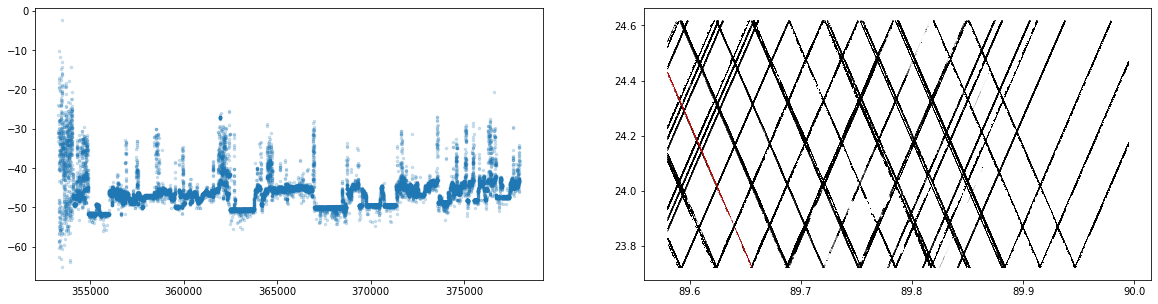

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# (df.series != 'Noise') & (df.series != 'Buffer') & 
data = df [(df.series != 'Noise') & (df.track_id == '180') & (df.date == '2020-01-07') & (df.beam == 'gt2r')]

ax[0].plot(data.h, '.', markersize=5, alpha=0.2)
ax[1].plot(df.lon, df.lat, 'k.', markersize=0.1, alpha=0.2)
ax[1].plot(data.lon, data.lat, 'r.', markersize=0.1, alpha=0.2)
plt.show()

In [28]:
data

,track_id,date,beam,series,lon,lat,h
353288,180,2020-01-07,gt2r,Buffer,89.627257,23.988047,-33.104588
353289,180,2020-01-07,gt2r,Buffer,89.625405,24.005350,-31.025043
353290,180,2020-01-07,gt2r,Buffer,89.621725,24.039676,-23.954815
353291,180,2020-01-07,gt2r,Buffer,89.591295,24.322734,-30.702648
353292,180,2020-01-07,gt2r,Buffer,89.591287,24.322817,-32.178750
...,...,...,...,...,...,...,...
377959,180,2020-01-07,gt2r,High,89.579642,24.430963,-43.297870
377960,180,2020-01-07,gt2r,High,89.579639,24.430995,-43.218304
377961,180,2020-01-07,gt2r,High,89.579637,24.431008,-43.392710
377962,180,2020-01-07,gt2r,High,89.579613,24.431225,-39.005028
